In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from model import encoder, decoder
from data_loader import DataLoaderforReconstOpt, DataLoaderforLatentOpt, DataLoaderforVocoder
from utils import connect

from config import wave_len
from config import window_size
from config import data_dim
from config import latent_dim
from config import batch_size
from config import n_choice

(10370160, 2) 48000


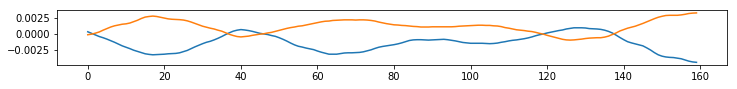

['../VoiceData/tamaneuta/trim_data/utama1.wav',
 '../VoiceData/tamaneuta/trim_data/utama2.wav',
 '../VoiceData/tamaneuta/trim_data/utama3.wav',
 '../VoiceData/tamaneuta/trim_data/utama4.wav',
 '../VoiceData/tamaneuta/trim_data/utama5.wav',
 '../VoiceData/tamaneuta/trim_data/utama6.wav',
 '../VoiceData/tamaneuta/trim_data/utama7.wav',
 '../VoiceData/tamaneuta/trim_data/utama8.wav',
 '../VoiceData/tamaneuta/trim_data/utama9.wav']

In [2]:
import soundfile as sf
import os

path = "../VoiceData/tamaneuta/trim_data/"
files = sorted(os.listdir(path))
files = [path + file for file in files]

data, rate = sf.read(files[0]) # rate == 48000 # samplerate:1秒あたりのフレーム数
print(data.shape, rate) # rateは最後のvocoder時に使う
plt.figure(figsize=(12,1))
plt.plot(data[10000:10000+wave_len])
plt.show()

files

In [3]:
inputs = tf.placeholder(tf.float32, (None, wave_len, data_dim))

with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
    encoded = encoder(tf.reshape(inputs, (-1, wave_len, 1, data_dim)))

with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
    decoded = tf.reshape(decoder(encoded), (-1, wave_len, data_dim))

variables =  tf.trainable_variables()
decoder_vars = [var for var in variables if 'decoder/' in var.name]

In [4]:
lr = 8e-4
beta1= 0.5
beta2 = 0.9

inputs_a = tf.placeholder(
    tf.float32, (None, 1, wave_len, data_dim))
inputs_B = tf.placeholder(
    tf.float32, (None, n_choice, wave_len, data_dim))

# ----------------------------------------------------------------
with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
    encoded_a = tf.reshape(
        encoder(tf.reshape(inputs_a, (-1, wave_len, 1, data_dim)))[0], # (?, 64)
        (-1, 1, latent_dim)) # (?, 1, 64)
print(encoded_a.shape) # (?, 1, 64)

# ----------------------------------------------------------------
_inputs_B = tf.split(inputs_B, num_or_size_splits=n_choice, axis=1) # (?, 1, 160, 2) x4
_encoded_B = [None]*n_choice # => (?, 1, 64) x4

for i in range(n_choice):
    with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
        _encoded_B[i] = tf.reshape(
            encoder(tf.reshape(_inputs_B[i], (-1, wave_len, 1, data_dim)))[0], # (?, 64)
            (-1, 1, latent_dim)) # (?, 1, 64)

encoded_B = tf.concat(_encoded_B, axis=1) # (?, 4, 64)
print(encoded_B.shape) # (?, 4, 64)

lat_acc = tf.reduce_mean(
    tf.one_hot(
        tf.argmin(
            tf.sqrt(tf.reduce_sum(tf.pow(
                encoded_B - encoded_a, # (batch_size, 4, latent_dim)
                2),axis=2)), # (batch_size, 4)
        axis=1), # (batch_size, 1) # 後ろの次元に最小値のindexを入れる
    depth=n_choice)[:,0] # 0番目の選択肢にだけ注目
)

print(lat_acc.shape)


# lat_loss = tf.losses.hinge_loss(
#     tf.constant(np.ones(batch_size)), # 目標ラインは1
#     1.0 - tf.nn.softmax( # 小さいほうが良いので、1から引く。
#         tf.sqrt(tf.reduce_sum(tf.pow(
#             encoded_B - encoded_a, # (batch_size, 4, latent_dim)
#             2),axis=2))
#     )[:,0]*2) # 正解選択肢が50%獲得することを目標にする（当選確実のライン）

lat_loss = tf.losses.hinge_loss(
    tf.constant(np.ones(batch_size)), # 目標ラインは1
    tf.nn.softmax(
        2.0 - tf.sqrt(tf.reduce_sum(tf.pow(
            encoded_B - encoded_a, # (batch_size, 4, latent_dim)
            2),axis=2))
    )[:,0]*2) # 正解選択肢が50%獲得することを目標にする（当選確実のライン）

print(lat_loss.shape)

# lat_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(lat_loss)

In [ ]:
lr = 8e-4
beta1= 0.5
beta2 = 0.9

lat_weight = tf.placeholder(tf.float32, 1)
kl_weight = tf.placeholder(tf.float32, 1)

opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(rec_loss+lat_loss*lat_weight+kl_loss*kl_weight)# 0.01

【wave】
amp: 0.026947021484375


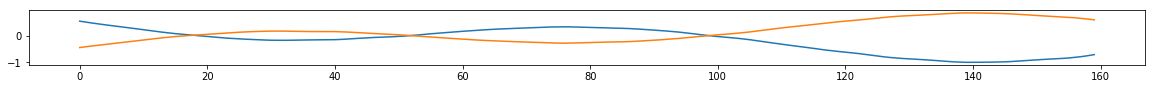

--------------------------------------------------------------------------------
amp: 0.05462646484375


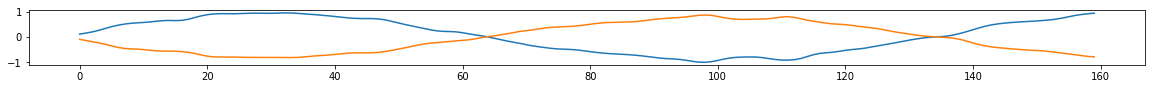

--------------------------------------------------------------------------------
amp: 0.048919677734375


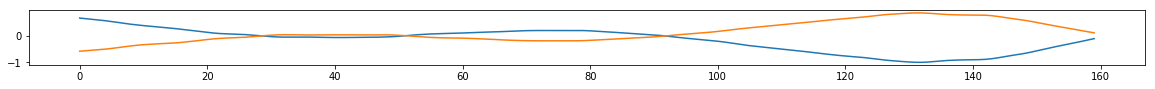

--------------------------------------------------------------------------------
amp: 0.01763916015625


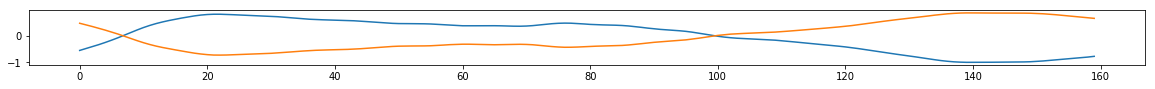

--------------------------------------------------------------------------------
【amp】 # max(amp)==0.231170654296875, mean(amp)==0.034743087195229845


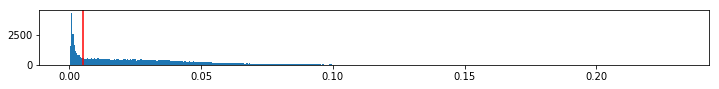

data.shape == (49716, 160, 2)
amp.shape == (49716,)


In [5]:
data_loader_rec = DataLoaderforReconstOpt(files)
_ = data_loader_rec.load(0, DEMO=True)

In [6]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

saver = tf.train.Saver() # tf.train.Saver(decoder_vars)
saver.restore(sess, './model/model-3')

epoch = 0

INFO:tensorflow:Restoring parameters from ./model/model-3


In [7]:
max_epoch = 3

In [8]:
from tqdm import tqdm

data_loader_rec = DataLoaderforReconstOpt(files)

for _ in range(epoch, max_epoch):    
    for file in range(len(files)):
        data, _ = data_loader_rec.load(file)
        rec_loss_hist = []
        for index in tqdm(range(0,len(data), batch_size)):
            batch = data[index:index+batch_size]
            
            _, _rec_loss = sess.run([rec_opt, rec_loss], {inputs: batch})
            
            rec_loss_hist.append(_rec_loss)
        print("epoch:", epoch+1, "file:", file+1, ", rec_loss:", np.mean(rec_loss_hist))
    saver.save(sess, './model/model', global_step=epoch+1)
    epoch += 1

100%|██████████| 389/389 [00:23<00:00, 16.34it/s]


epoch: 1 file: 1 , rec_loss: 0.0139548825


100%|██████████| 423/423 [00:19<00:00, 21.41it/s]


epoch: 1 file: 2 , rec_loss: 0.0053839786


100%|██████████| 410/410 [00:18<00:00, 22.44it/s]


epoch: 1 file: 3 , rec_loss: 0.0040817945


100%|██████████| 397/397 [00:17<00:00, 22.08it/s]


epoch: 1 file: 4 , rec_loss: 0.002888973


100%|██████████| 415/415 [00:19<00:00, 21.81it/s]


epoch: 1 file: 5 , rec_loss: 0.0026093724


100%|██████████| 443/443 [00:20<00:00, 21.94it/s]


epoch: 1 file: 6 , rec_loss: 0.0022098997


100%|██████████| 423/423 [00:19<00:00, 21.68it/s]


epoch: 1 file: 7 , rec_loss: 0.0027226093


100%|██████████| 397/397 [00:18<00:00, 21.09it/s]


epoch: 1 file: 8 , rec_loss: 0.002165237


100%|██████████| 397/397 [00:18<00:00, 21.51it/s]


epoch: 1 file: 9 , rec_loss: 0.0023026583


100%|██████████| 389/389 [00:18<00:00, 21.10it/s]


epoch: 2 file: 1 , rec_loss: 0.0013956194


100%|██████████| 423/423 [00:19<00:00, 21.35it/s]


epoch: 2 file: 2 , rec_loss: 0.0015258353


100%|██████████| 410/410 [00:18<00:00, 21.97it/s]


epoch: 2 file: 3 , rec_loss: 0.0015714796


100%|██████████| 397/397 [00:17<00:00, 22.17it/s]


epoch: 2 file: 4 , rec_loss: 0.0015438459


100%|██████████| 415/415 [00:19<00:00, 21.61it/s]


epoch: 2 file: 5 , rec_loss: 0.0014773073


100%|██████████| 443/443 [00:20<00:00, 22.04it/s]


epoch: 2 file: 6 , rec_loss: 0.0015365483


100%|██████████| 423/423 [00:19<00:00, 22.06it/s]


epoch: 2 file: 7 , rec_loss: 0.0017662235


100%|██████████| 397/397 [00:18<00:00, 21.67it/s]


epoch: 2 file: 8 , rec_loss: 0.001514695


100%|██████████| 398/398 [00:18<00:00, 21.23it/s]


epoch: 2 file: 9 , rec_loss: 0.0018400385


100%|██████████| 389/389 [00:17<00:00, 21.70it/s]


epoch: 3 file: 1 , rec_loss: 0.0010867786


100%|██████████| 423/423 [00:19<00:00, 21.63it/s]


epoch: 3 file: 2 , rec_loss: 0.0011816666


100%|██████████| 410/410 [00:19<00:00, 21.38it/s]


epoch: 3 file: 3 , rec_loss: 0.0012755513


100%|██████████| 397/397 [00:18<00:00, 21.46it/s]


epoch: 3 file: 4 , rec_loss: 0.001176897


100%|██████████| 415/415 [00:19<00:00, 20.92it/s]


epoch: 3 file: 5 , rec_loss: 0.0011333189


100%|██████████| 443/443 [00:20<00:00, 21.12it/s]


epoch: 3 file: 6 , rec_loss: 0.0010542724


100%|██████████| 423/423 [00:19<00:00, 21.90it/s]


epoch: 3 file: 7 , rec_loss: 0.0012545354


100%|██████████| 397/397 [00:18<00:00, 21.09it/s]


epoch: 3 file: 8 , rec_loss: 0.0011306565


100%|██████████| 398/398 [00:19<00:00, 20.17it/s]

epoch: 3 file: 9 , rec_loss: 0.0012304127


In [9]:
saver.save(sess, './model/model', global_step=epoch)

'./model/model-3'

inputs -> decoded
amp: 0.0130615234375


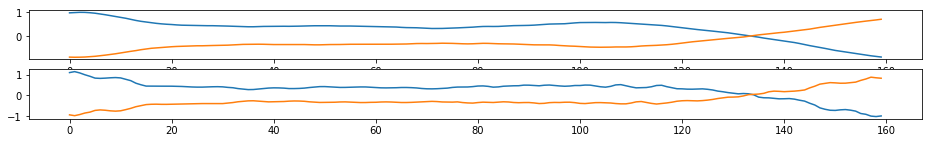

amp: 0.040435791015625


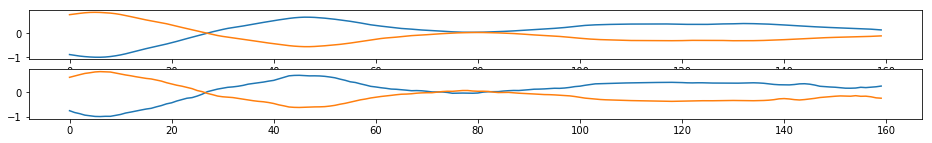

amp: 0.0115966796875


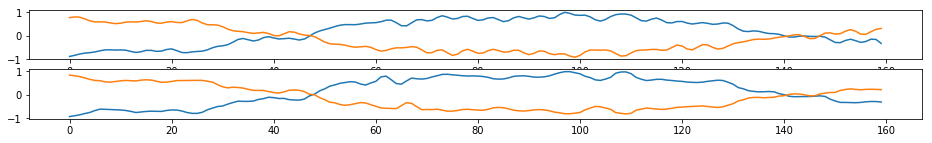

amp: 0.06658935546875


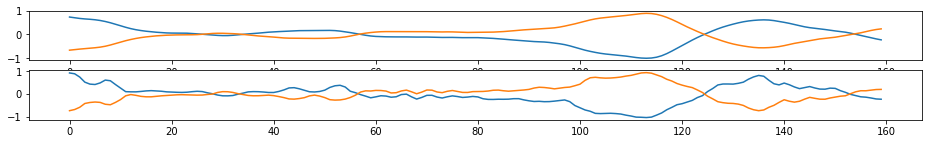

In [8]:
data_loader_rec = DataLoaderforReconstOpt(files)
data, amp = data_loader_rec.load(0)

print("inputs -> decoded")

for i in range(4):

    index = np.random.choice(len(data))
    x = data[index]
    a = amp[index]
    print("amp:", a)

    _x = x.reshape(wave_len, data_dim)
    plt.figure(figsize=(16,2));
    plt.subplot(2,1,1); plt.plot(_x);

    x = sess.run(decoded, {inputs: [_x]})
    plt.subplot(2,1,2); plt.plot(x[0]); plt.show()

### AutoEncode

In [10]:
from tqdm import tqdm

data_loader_voc = DataLoaderforVocoder(files)

ae_data = []

print("autoencoding...")

for fi in range(1):
    batch_size = 128
    data, amp = data_loader_voc.load(fi)

    for index in tqdm(range(0, len(data), batch_size)):
        batch_data = data[index:index+batch_size]
        batch_amp = amp[index:index+batch_size]
        _ae_data = sess.run(decoded, {inputs: batch_data})
        if not _ae_data.shape == (batch_size, 160,2):
            continue
        ae_data.extend(_ae_data*batch_amp.reshape(-1,1,1))       

ae_data = np.array(ae_data)
print("ae_data.shape ==", ae_data.shape)

print("connecting...")

concat_data = [ae_data[0, 60:-20]]

for _ae_data in tqdm(ae_data[1:]):
    _ae_data = _ae_data[20:-20] # 新しいデータ。最初と最後は切り捨てておく。(1560, 2)
    a = concat_data[-1][-40:] # 古いデータの尻。(40, 2)
    b = _ae_data[:40] # 新しいデータの頭。(40, 2)
    concat_data[-1][-40:,0] = connect(a[:,0],b[:,0]) # 古いデータを上書き
    concat_data[-1][-40:,1] = connect(a[:,1],b[:,1]) # 古いデータを上書き
    
    concat_data.append(_ae_data[40:])

print("writing...")

concat_data = np.array(concat_data).reshape(-1, data_dim)
sf.write("sample/1_ae-short-3ep.wav", concat_data, rate)

print("done")

autoencoding...


  2%|▏         | 2139/129535 [00:00<00:11, 10693.19it/s]

ae_data.shape == (129536, 160, 2)
connecting...


100%|██████████| 129535/129535 [00:11<00:00, 10864.02it/s]


writing...
done


### Encoder
- 潜在空間への写像の様子をプロット

100%|██████████| 388/388 [00:03<00:00, 127.36it/s]

(49536, 64)


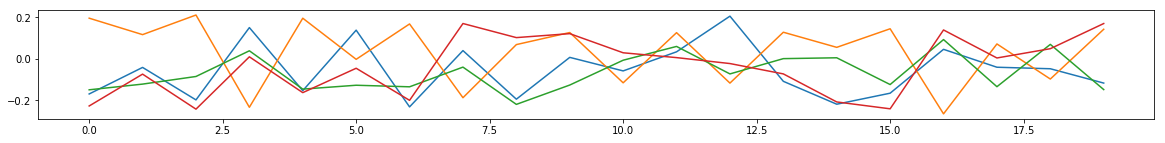

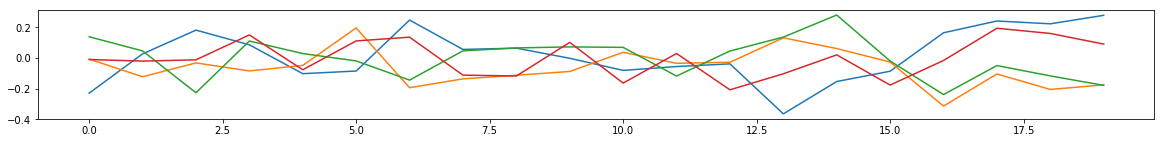

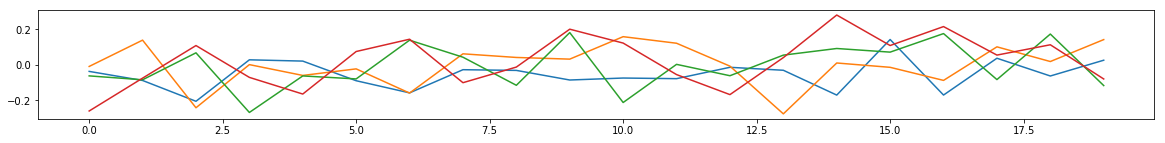

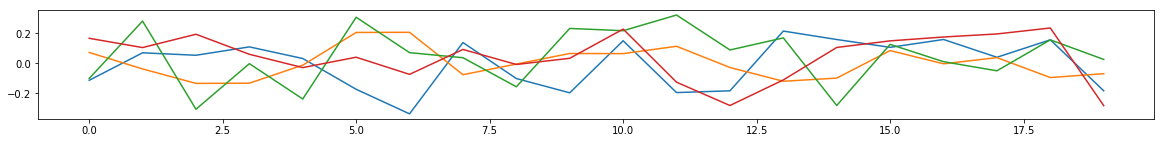

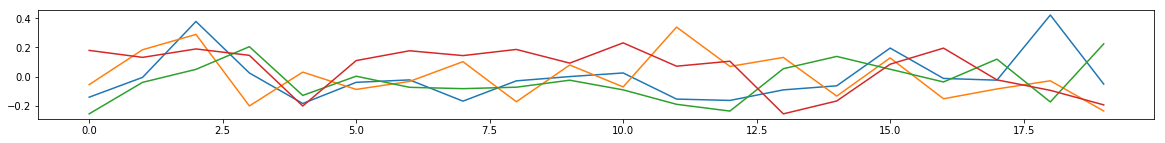

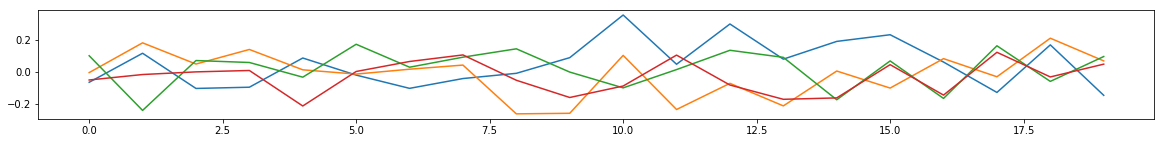

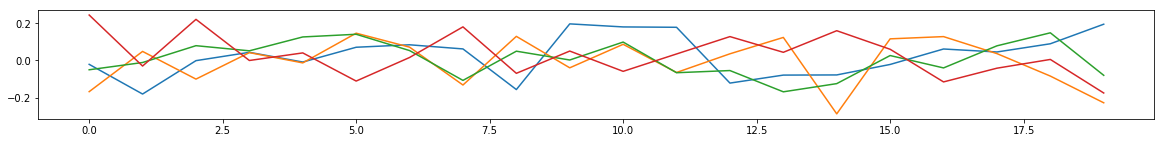

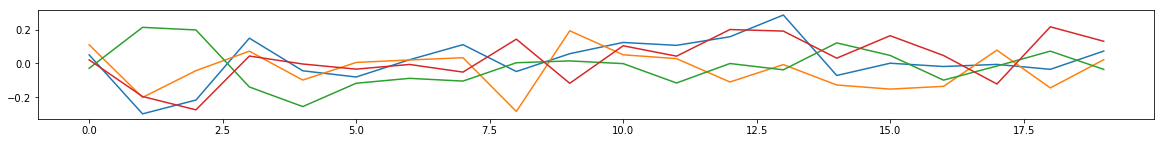

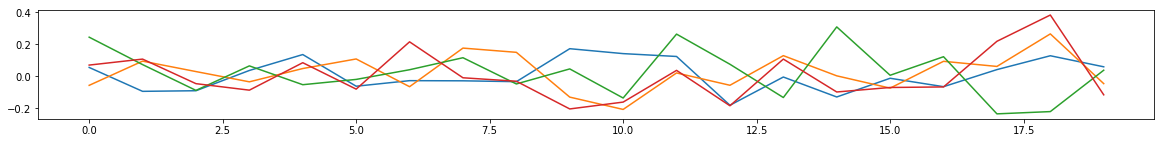

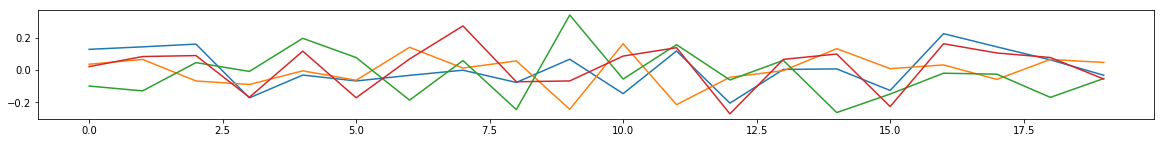

In [13]:
data_loader_rec = DataLoaderforReconstOpt(files)

ae_data = []

for fi in range(1):
    batch_size = 128
    data, amp = data_loader_rec.load(fi)

    for index in tqdm(range(0, len(data), batch_size)):
        batch_data = data[index:index+batch_size]
        batch_amp = amp[index:index+batch_size]
#         print(batch_data.shape) # (128, 160, 2)
        _ae_data = sess.run(encoded, {inputs: batch_data})
#         print(_ae_data.shape) # (128, 64)
        if not _ae_data.shape == (batch_size, latent_dim):
            continue
        ae_data.extend(_ae_data)

ae_data = np.array(ae_data)
print(ae_data.shape)

for i in range(10):
    plt.figure(figsize=(20,2))
    _s = np.random.randint(len(ae_data)-10)
    _e = _s+20
    plt.plot(ae_data[_s:_e,i:i+4])
    plt.show()